## Importations

In [ ]:
!pip install geopandas


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams.update({'font.size': 18})

In [ ]:
# Charger la carte GeoJSON des départements français
map_data = gpd.read_file('departements.geojson')
map_data 

,code,nom,geometry
0,02,Aisne,"POLYGON ((3.17270 50.01200, 3.18220 50.01234, ..."
1,10,Aube,"POLYGON ((3.41479 48.39027, 3.42208 48.41334, ..."
2,14,Calvados,"POLYGON ((-1.11962 49.35557, -1.11503 49.36240..."
3,15,Cantal,"POLYGON ((2.50841 45.47850, 2.52444 45.48070, ..."
4,28,Eure-et-Loir,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
...,...,...,...
91,41,Loir-et-Cher,"POLYGON ((0.84122 48.10306, 0.87588 48.10943, ..."
92,53,Mayenne,"POLYGON ((-0.86036 48.50146, -0.84611 48.49828..."
93,54,Meurthe-et-Moselle,"MULTIPOLYGON (((5.45556 49.48093, 5.44953 49.4..."
94,79,Deux-Sèvres,"POLYGON ((-0.89196 46.97582, -0.87973 46.97580..."


# Carte des prévalences par département

In [ ]:
df = pd.read_csv("france_cancers_poumon.csv", names=['dept', 'prev'])
df.drop([0], axis=0, inplace=True)
df['prev'] = -df['prev'].astype(float) #on change l'ordre relatif pour dresser une comparaison avec la carte trouvée sur internet (cf rapport)
for i in range(1,10): #il faut que les numeros des departements soient 01,02 et non pas 1,2 pour faire un join correct avec le dataframe GeoJson
    df.loc[df.index[i-1], "dept"] = "0" + str(i)

df2 = pd.DataFrame([["86",-0.5]], columns=['dept','prev']) #on impute à la main la valeur pour la Vienne (86)
df = df.append(df2, ignore_index=True)
df.sort_values(by = 'dept', inplace=True)
df


<ipython-input-33-3e5753440e05>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)


,dept,prev
0,01,-0.410124
1,02,-0.576241
2,03,-0.579010
3,04,-0.467356
4,05,-0.402074
...,...,...
88,91,-0.417077
89,92,-0.422756
90,93,-0.430636
91,94,-0.420362


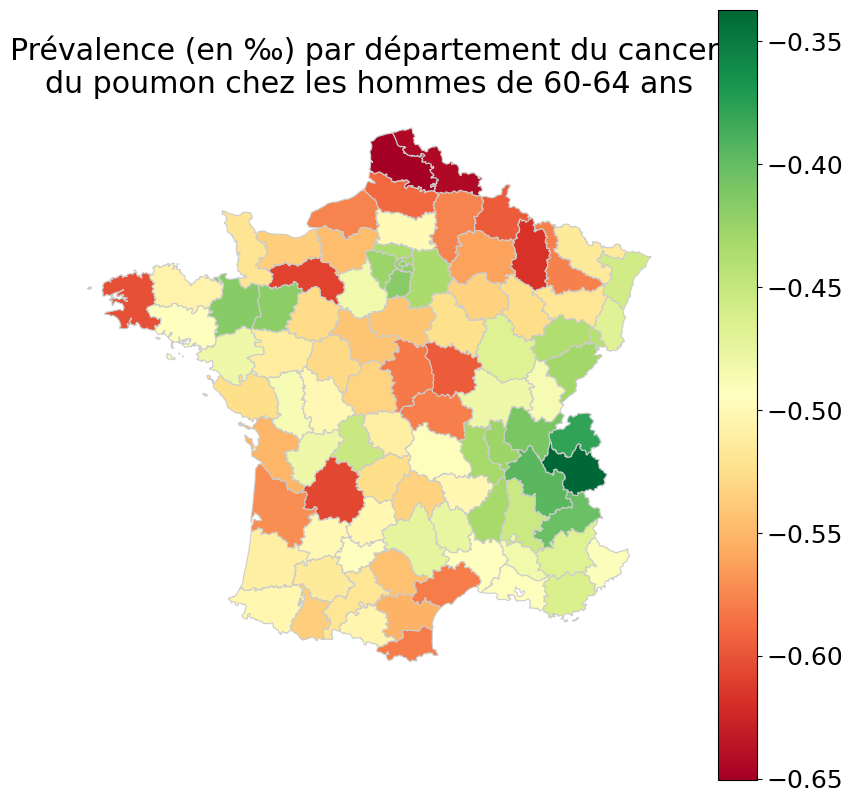

In [ ]:
#on fusionne le dataframe GeoJson avec le dataframe des prévalences par département
merged_data = map_data.merge(df, left_on='code', right_on='dept', how='left')

#on cree la figure
fig, ax = plt.subplots(figsize=(10, 10))

#options de tracé ci dessous : couleur, titre, on enleve les axes...
merged_data.plot(column='prev', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8')
sm = plt.cm.ScalarMappable(cmap='RdYlGn')
sm.set_array(merged_data['prev'])
plt.colorbar(sm, ax=ax)

plt.grid(False)
plt.axis("off")


plt.title('Prévalence (en ‰) par département du cancer \ndu poumon chez les hommes de 60-64 ans')

plt.savefig("prevalence_par_departement.pdf")


plt.show()

# Français sans hopitaux à moins de 20km

In [ ]:
nb_habitants_isoles = pd.read_csv("nb_habitants_isoles_20km.csv", names=['dept', 'nbhabisoles'])
#on recupere le nombre d'habitants isolés résultat d'une requete Cypher
nb_habitants_isoles.drop([0], axis=0, inplace=True)
nb_habitants_isoles

,dept,nbhabisoles
1,1,0
2,2,0
3,3,3144
4,4,0
5,5,3216
...,...,...
91,91,4353
92,92,0
93,93,0
94,94,0


In [ ]:
nb_habitants_departements = pd.read_csv("nb_habitants_departement.csv", names=['dept', 'nbhab'])
nb_habitants_departements.drop([0], axis=0, inplace=True)
#on recupere le nombre d'habitants par département résultat d'une requete Cypher
nb_habitants_departements

,dept,nbhab
1,1,390732.0
2,2,227265.0
3,3,179477.0
4,4,92498.0
5,5,70687.0
...,...,...
91,91,1282669.0
92,92,1622583.0
93,93,1644903.0
94,94,1407124.0


In [ ]:
nb_hab_dept_liste = list(nb_habitants_departements.nbhab)
nb_hab_dept_liste = np.array([float(elem) for elem in nb_hab_dept_liste])

nb_hab_isoles_liste = list(nb_habitants_isoles.nbhabisoles)
nb_hab_isoles_liste = np.array([float(elem) for elem in nb_hab_isoles_liste])

array2 = nb_hab_isoles_liste/nb_hab_dept_liste
df2 = pd.Series(data = array2, name='%nbhabisoles', index=np.arange(1,96))

df3 = pd.Series(data = np.arange(1,96), name = 'dept', index = np.arange(1,96))

df = pd.concat([df3, df2], ignore_index=True, axis=1)
df.columns = ['dept', '%nbhabisoles']


for i in range(1,10):
    df.loc[nb_habitants_isoles.index[i-1], "dept"] = "0" + str(i)
for i in range(10,96): 
    df.loc[nb_habitants_isoles.index[i-1], "dept"] = str(i)

df.iloc[85,1] = 0.3 #Vienne (86) imputé a la main

df2 = pd.DataFrame([["48", 0.6]], columns=['dept', '%nbhabisoles']) #Lozere (48) imputé a la main
df = df.append(df2, ignore_index=True)
df2 = pd.DataFrame([["75", 0.]], columns=['dept', '%nbhabisoles']) #Paris (75) imputé a la main
df = df.append(df2, ignore_index=True)
df.sort_values(by = 'dept', inplace=True)
df.head(89)

<ipython-input-69-6fc25ee7faec>:7: RuntimeWarning: invalid value encountered in true_divide
  array2 = nb_hab_isoles_liste/nb_hab_dept_liste
<ipython-input-69-6fc25ee7faec>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)
<ipython-input-69-6fc25ee7faec>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)


,dept,%nbhabisoles
0,01,0.000000
1,02,0.000000
2,03,0.017518
3,04,0.000000
4,05,0.045496
...,...,...
82,83,0.005170
83,84,0.000000
84,85,0.148966
85,86,0.300000


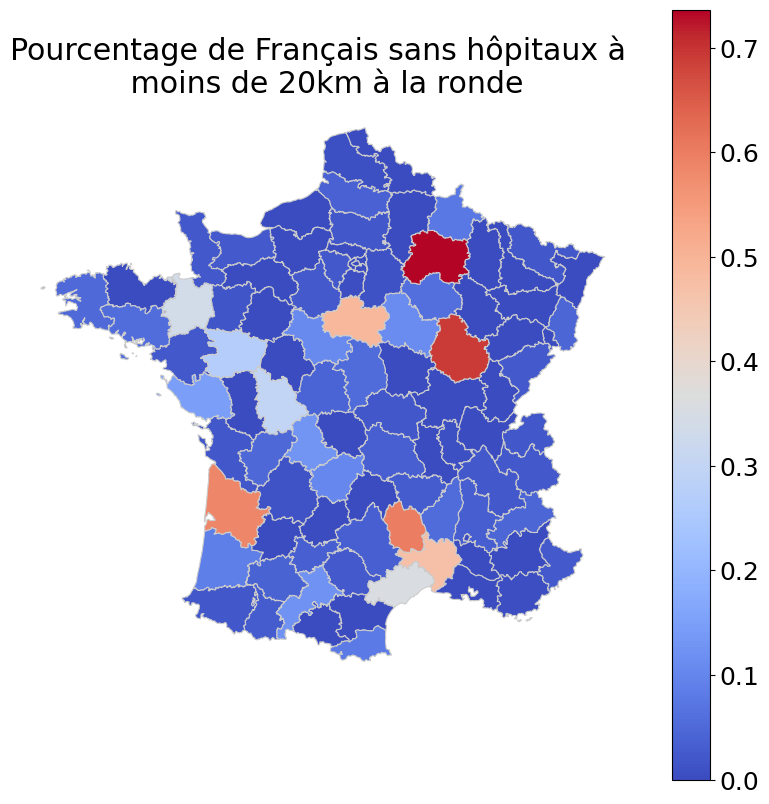

In [ ]:
merged_data = map_data.merge(df, left_on='code', right_on='dept', how='left')


fig, ax = plt.subplots(figsize=(10, 10))


merged_data.plot(column='%nbhabisoles', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')


sm = plt.cm.ScalarMappable(cmap='coolwarm')
sm.set_array(merged_data['%nbhabisoles'])
plt.colorbar(sm, ax=ax)

plt.grid(False)
plt.axis("off")


plt.title('Pourcentage de Français sans hôpitaux à \n moins de 20km à la ronde')

plt.savefig("francais_sans_hopitaux.pdf")

plt.show()

# Nombre d'hopitaux par departement


In [ ]:
df = pd.read_csv("nb_hopitaux_per_dept.csv", names=['dept', 'nb_hopitaux'])
df.drop([0], axis=0, inplace=True)

for i in range(1,10):
    df.loc[df.index[i-1], "dept"] = "0" + str(i)


df2 = pd.DataFrame([["86",0]], columns=['dept','nb_hopitaux']) #on a besoin d'ajouter manuellement que le departement de la Vienne (86) n'a pas de centres hospitaliers
df = df.append(df2, ignore_index=True)
df.sort_values(by = 'dept', inplace=True)
df

<ipython-input-23-49271abc1eef>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)


,dept,nb_hopitaux
0,01,15
1,02,15
2,03,18
3,04,17
4,05,12
...,...,...
89,92,15
90,93,7
91,94,11
92,95,26


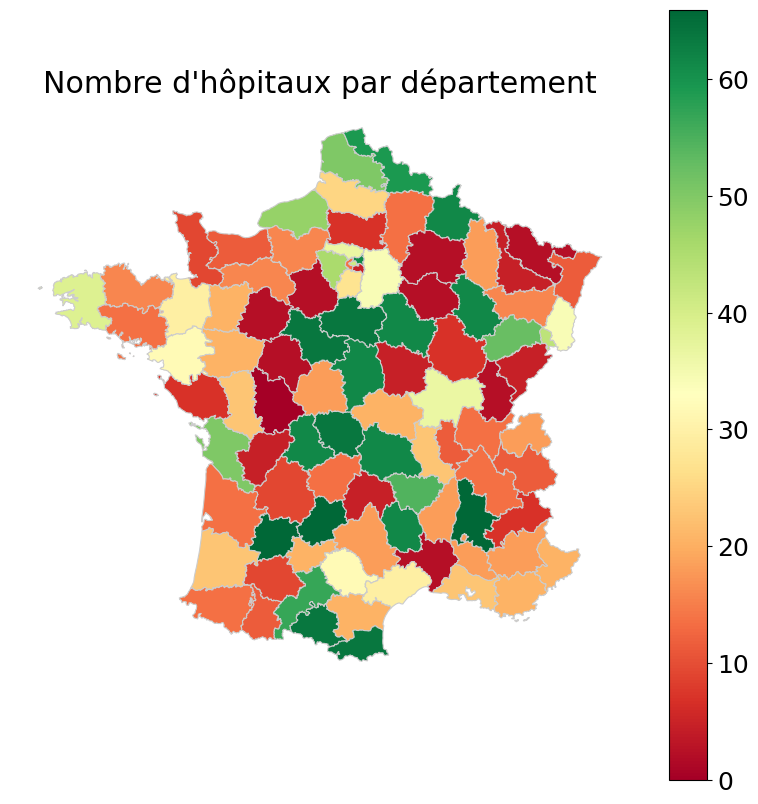

In [ ]:
merged_data = map_data.merge(df, left_on='code', right_on='dept', how='left')


fig, ax = plt.subplots(figsize=(10, 10))


merged_data.plot(column='nb_hopitaux', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8')


sm = plt.cm.ScalarMappable(cmap='RdYlGn')
sm.set_array(merged_data['nb_hopitaux'].astype(float))
plt.colorbar(sm, ax=ax)

plt.grid(False)
plt.axis("off")


plt.title("Nombre d'hôpitaux par département")

plt.savefig("nb_hopitaux_par_departement.pdf")


plt.show()

# Distance moyenne au plus proche hôpital 

In [ ]:
df = pd.read_csv("distance_minimale_moyenne.csv", names=['dept', 'dist_moyenne'])
df.drop([0], axis=0, inplace=True)

for i in range(1,10):
    df.loc[df.index[i-1], "dept"] = "0" + str(i)

print(type(df.dist_moyenne.iloc[0]))

df2 = pd.DataFrame([["48","30"]], columns=['dept','dist_moyenne']) #on a besoin d'ajouter manuellement que le departement de la Lozere (86) a une distance moyenne tres elevee
df = df.append(df2, ignore_index=True)
df2 = pd.DataFrame([["75","10"]], columns=['dept','dist_moyenne']) #on a besoin d'ajouter manuellement que le departement de Paris (75) a une distance moyenne tres faible
df = df.append(df2, ignore_index=True)
df.sort_values(by = 'dept', inplace=True)
df

<class 'str'>


<ipython-input-8-560142afd206>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)
<ipython-input-8-560142afd206>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)


,dept,dist_moyenne
0,01,8.572421221167069
1,02,4.648995902651765
2,03,5.398167824229267
3,04,4.950175462588579
4,05,6.438518066112754
...,...,...
87,91,5.048908573736317
88,92,3.151768339401483
89,93,3.141831614034108
90,94,3.1977379827119283


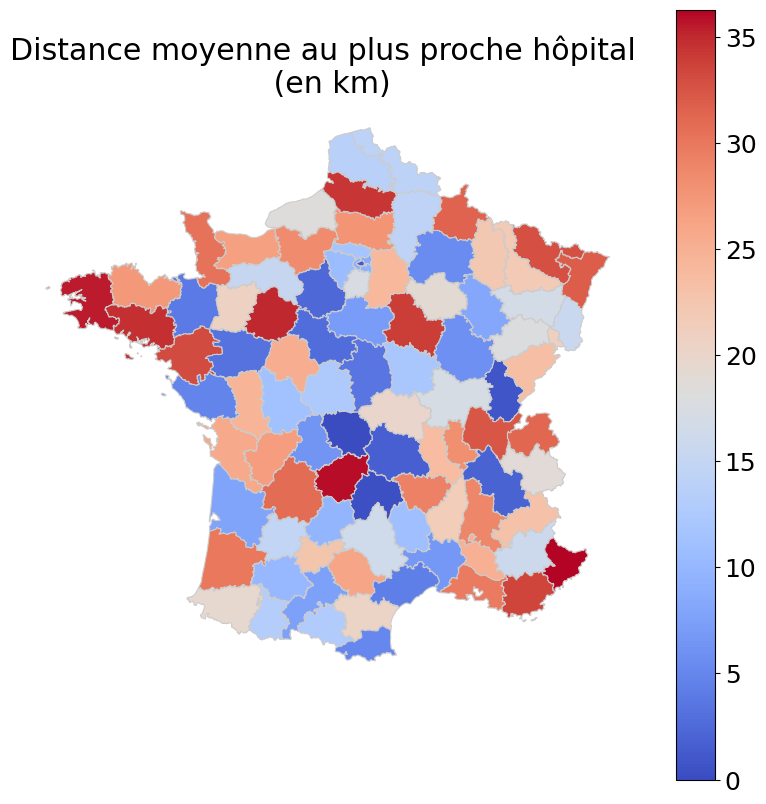

In [ ]:
merged_data = map_data.merge(df, left_on='code', right_on='dept', how='left')


fig, ax = plt.subplots(figsize=(10, 10))


merged_data.plot(column='dist_moyenne', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')


sm = plt.cm.ScalarMappable(cmap='coolwarm')
sm.set_array(merged_data['dist_moyenne'].astype(float))
plt.colorbar(sm, ax=ax)

plt.grid(False)
plt.axis("off")


plt.title('Distance moyenne au plus proche hôpital \n (en km)')

plt.savefig("distance_moyenne.pdf")


plt.show()